# Código TP3: Clustering

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html
from sklearn.preprocessing import scale

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

## Carga de Datasets "Crabs"

In [3]:
crabs = pd.read_csv("Crabs.csv", sep=',')
crabs = crabs.drop(columns=["rownames", "index"])
print(crabs)

crabs_numpy = crabs.to_numpy()
print(crabs_numpy)

    sp sex    FL    RW    CL    CW    BD
0    B   M   8.1   6.7  16.1  19.0   7.0
1    B   M   8.8   7.7  18.1  20.8   7.4
2    B   M   9.2   7.8  19.0  22.4   7.7
3    B   M   9.6   7.9  20.1  23.1   8.2
4    B   M   9.8   8.0  20.3  23.0   8.2
..  ..  ..   ...   ...   ...   ...   ...
195  O   F  21.4  18.0  41.2  46.2  18.7
196  O   F  21.7  17.1  41.7  47.2  19.6
197  O   F  21.9  17.2  42.6  47.4  19.5
198  O   F  22.5  17.2  43.0  48.7  19.8
199  O   F  23.1  20.2  46.2  52.5  21.1

[200 rows x 7 columns]
[['B' 'M' 8.1 ... 16.1 19.0 7.0]
 ['B' 'M' 8.8 ... 18.1 20.8 7.4]
 ['B' 'M' 9.2 ... 19.0 22.4 7.7]
 ...
 ['O' 'F' 21.9 ... 42.6 47.4 19.5]
 ['O' 'F' 22.5 ... 43.0 48.7 19.8]
 ['O' 'F' 23.1 ... 46.2 52.5 21.1]]


## Carga de Datasets "Lampone"

In [4]:
lampone = pd.read_csv("Lampone.csv", sep=',')
print(lampone)

lampone_numpy = lampone.to_numpy()
print(lampone_numpy)

    anno     m33   m34   m35   m36  m40   m41   m42    m43   m44  ...  m183  \
0   2006   32.24  0.27  0.06  0.01  0.0  0.30  0.02   2.05  0.11  ...  0.00   
1   2006   33.41  0.34  0.05  0.01  0.0  0.12  0.02  10.42  0.25  ...  0.00   
2   2006   31.93  0.32  0.05  0.01  0.0  0.09  0.02   9.32  0.24  ...  0.00   
3   2006   43.62  0.45  0.08  0.02  0.0  0.11  0.02  12.67  0.31  ...  0.00   
4   2006   47.08  0.47  0.09  0.02  0.0  0.20  0.03   3.19  0.12  ...  0.00   
5   2006   21.38  0.20  0.03  0.00  0.0  0.06  0.01  12.01  0.27  ...  0.00   
6   2006   37.20  0.38  0.06  0.01  0.0  0.07  0.02   3.45  0.14  ...  0.00   
7   2006   57.00  0.51  0.08  0.00  0.0  0.08  0.02   2.63  0.09  ...  0.00   
8   2006   13.31  0.16  0.02  0.00  0.0  0.14  0.02  11.92  0.26  ...  0.00   
9   2006  122.75  1.05  0.17  0.01  0.0  0.11  0.02   8.67  0.24  ...  0.00   
10  2006   37.70  0.37  0.05  0.00  0.0  0.09  0.02  19.00  0.39  ...  0.00   
11  2006   39.47  0.38  0.06  0.01  0.0  0.15  0.02 

## Métodos de Comparación de Resultados

In [5]:
# Comentario: para comparar dos soluciones de clustering o una de ellas
#  contra las clases originales se suele usar una tabla, como por ejemplo:

def comparar_tabla(clusters1, clusters2):

    # Suponemos a los clusters numerados desde 0
    nclusters1 = np.max(clusters1) + 1
    nclusters2 = np.max(clusters2) + 1

    conf_matrix = np.zeros((nclusters1, nclusters2), dtype=int)

    for i in range(len(clusters1)):
        conf_matrix[clusters1[i], clusters2[i]] += 1

    print(conf_matrix)
    return conf_matrix


# pero se puede optimizar el match entre los dos clusterings, para hacer
# mejor la tabla, usando:

def comparar_tabla_optim(clusters1, clusters2, print_matrix=False):

    # Suponemos a los clusters numerados desde 0
    nclusters1 = np.max(clusters1) + 1
    nclusters2 = np.max(clusters2) + 1

    conf_matrix = np.zeros((nclusters1, nclusters2), dtype=int)

    for i in range(len(clusters1)):
        conf_matrix[clusters1[i], clusters2[i]] += 1

    # minimum weight matching, optimize the matching between a cluster
    # in clusters1 with one or more clusters in clusters2
    _, col_ind = linear_sum_assignment(-conf_matrix)
    optimized_conf_matrix = conf_matrix[:, col_ind]

    if print_matrix:
        print(optimized_conf_matrix)
    return optimized_conf_matrix

def precision_conf_matrix(conf_matrix):
    correct = np.trace(conf_matrix)
    total = np.sum(conf_matrix)
    accuracy = correct / total
    return accuracy



## Score de Estabilidad de Soluciones de Clustering

In [6]:
# Código de ejemplo de como calcular el score de estabilidad de dos soluciones
# de clustering usando Iris

data = load_iris()
X = data.data
n = X.shape[0]

# Fijar el número de clusters
k = 3

# Crear dos muestras aleatorias del 90% de los datos
ind1 = np.random.choice(n, int(0.9 * n), replace=False)
ind2 = np.random.choice(n, int(0.9 * n), replace=False)

# Aplicar K-Means a ambas muestras
cc1 = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X[ind1]).labels_
cc2 = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X[ind2]).labels_

# Reinsertar los clusters en un vector de longitud n, con 0 en los puntos
# no seleccionados
v1 = np.zeros(n, dtype=int)
v2 = np.zeros(n, dtype=int)

# Se suman 5 a las etiquetas para permitir el truco de la raíz cuadrada
v1[ind1] = cc1 + 5
v2[ind2] = cc2 + 5

# Crear la matriz de similitud: 1 si están en el mismo cluster,
# -1 si están en distinto, 0 si alguno falta
def compute_similarity_matrix(v):
    a = np.sqrt(np.outer(v, v))
    m = np.divide(a, -a, out=np.zeros_like(a), where=a != 0) + 2 * (a == np.round(a))
    return m

m1 = compute_similarity_matrix(v1)
m2 = compute_similarity_matrix(v2)

# Calcular el score de estabilidad
validos = np.sum((v1 * v2) > 0)
if validos > 1:
    score = np.sum((m1 * m2)[np.triu_indices(n, k=1)] > 0) / (validos * (validos - 1) / 2)
else:
    score = 0  # Evita división por cero

print(score)

1.2081018832136567


# Ejercicio 1

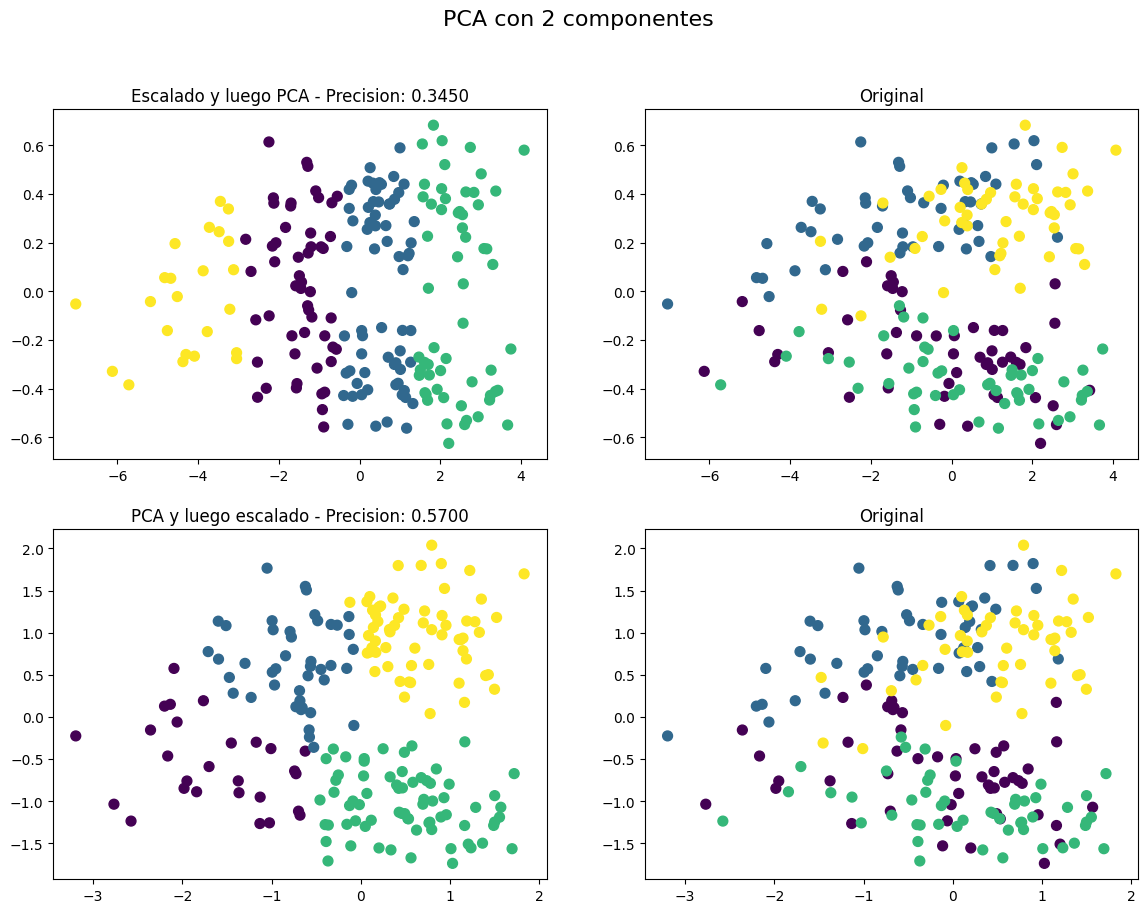

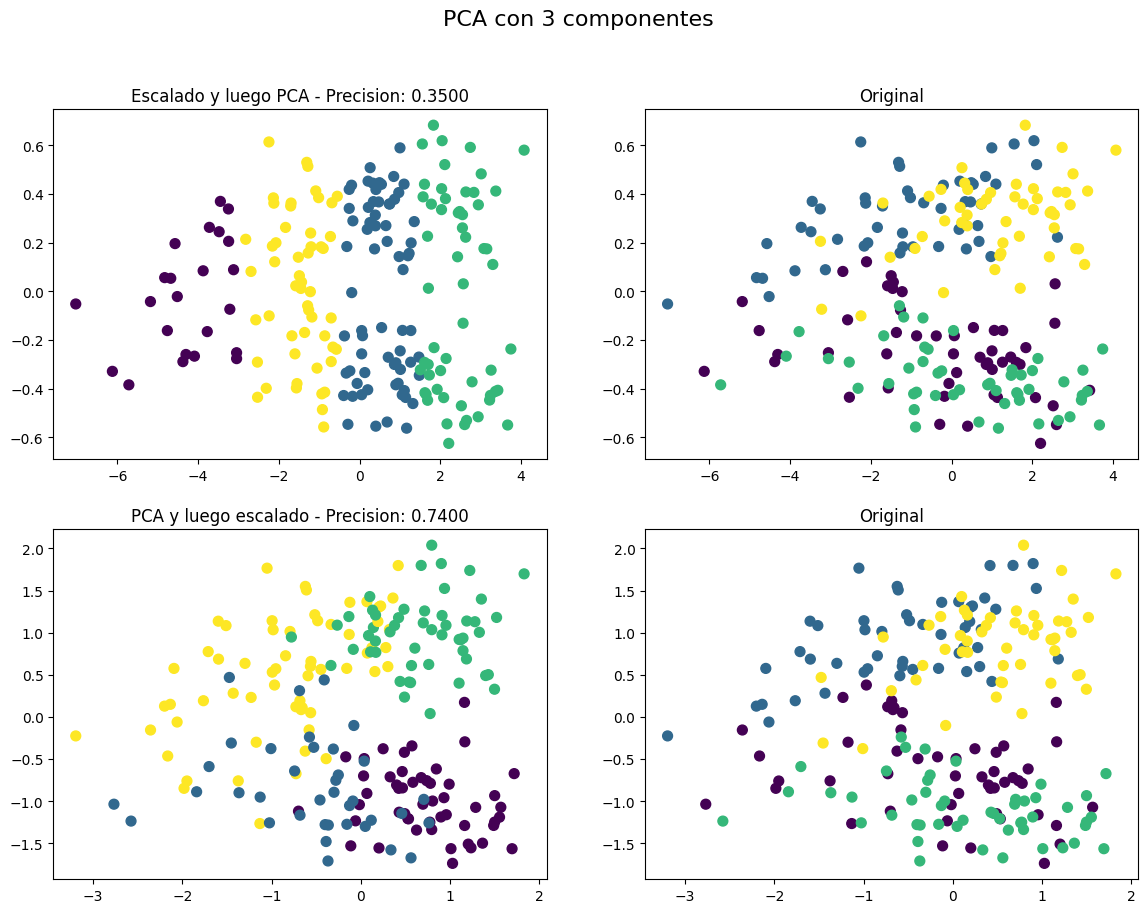

In [7]:
X = crabs.drop(columns=["sp", "sex"])
y = crabs[["sp", "sex"]]
original = pd.factorize(pd.Series(zip(y["sp"], y["sex"])))[0]

X_log = np.log(X)
X_scaled = scale(X_log, axis=0)

# Probar PCA con 2 y 3 componentes
components_list = [2,3]
for components in components_list:
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X_log)
    X_pca_scaled = scale(X_pca, axis=0)

    pca = PCA(n_components=components)
    X_scaled_pca = pca.fit_transform(X_scaled)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"PCA con {components} componentes", fontsize=16)

    # 4 clusters ya que hay dos especies y dos sexos
    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_scaled_pca)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[0][0].set_title("Escalado y luego PCA - " + f"Precision: {precision:.4f}")
    axes[0][0].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=clusters, cmap="viridis", s=50)
    axes[0][1].set_title("Original")
    axes[0][1].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=original, cmap="viridis", s=50)

    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_pca_scaled)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[1][0].set_title("PCA y luego escalado - " + f"Precision: {precision:.4f}")
    axes[1][0].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=clusters, cmap="viridis", s=50)
    axes[1][1].set_title("Original")
    axes[1][1].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=original, cmap="viridis", s=50)

# Para 3 componentes de PCA
#fig = plt.figure(figsize=(10, 7))
#ax = fig.add_subplot(111, projection='3d')
#
#scatter = ax.scatter(
#    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
#    c=clusters, cmap='viridis', s=50
#)
#ax.set_xlabel("PCA 1")
#ax.set_ylabel("PCA 2")
#ax.set_zlabel("PCA 3")
#ax.set_title("K-Means Clusters (3D PCA of Crabs Dataset)")
#
#plt.colorbar(scatter, label='Cluster')
#plt.show()


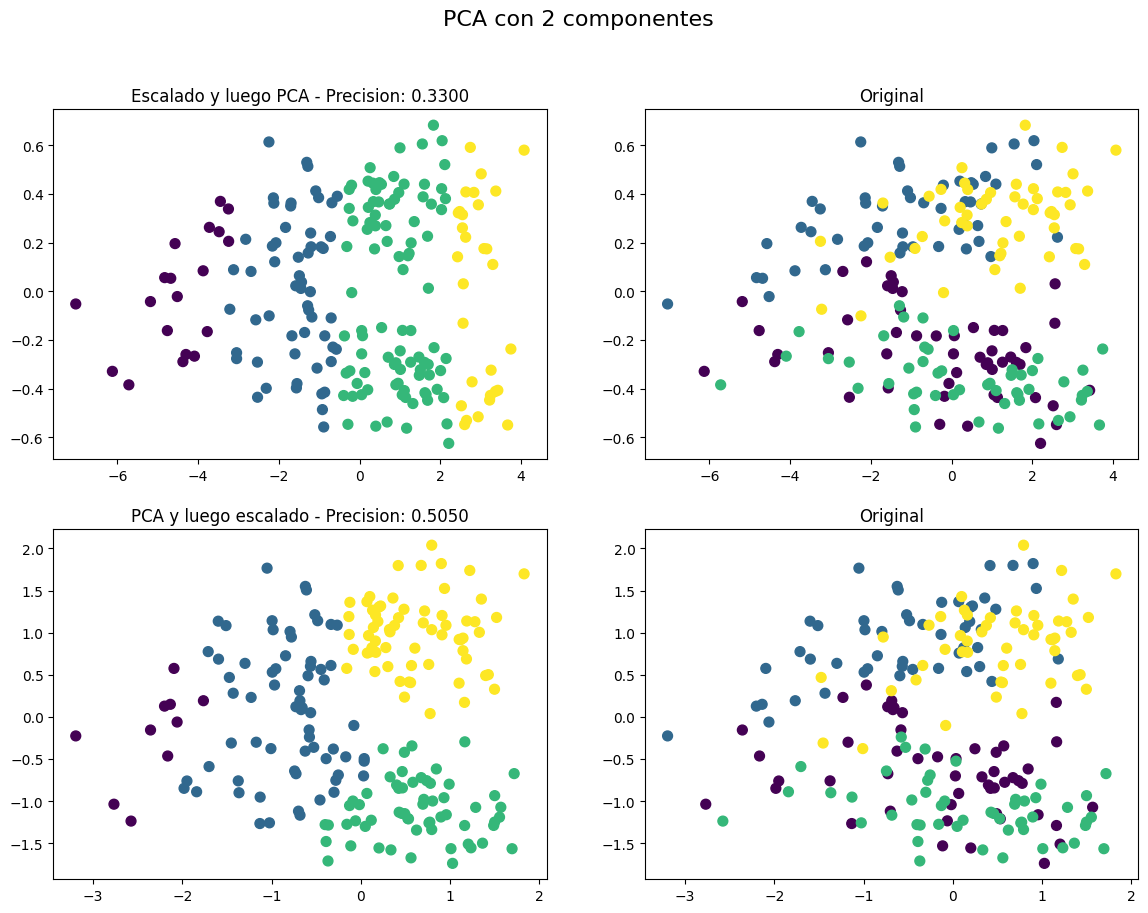

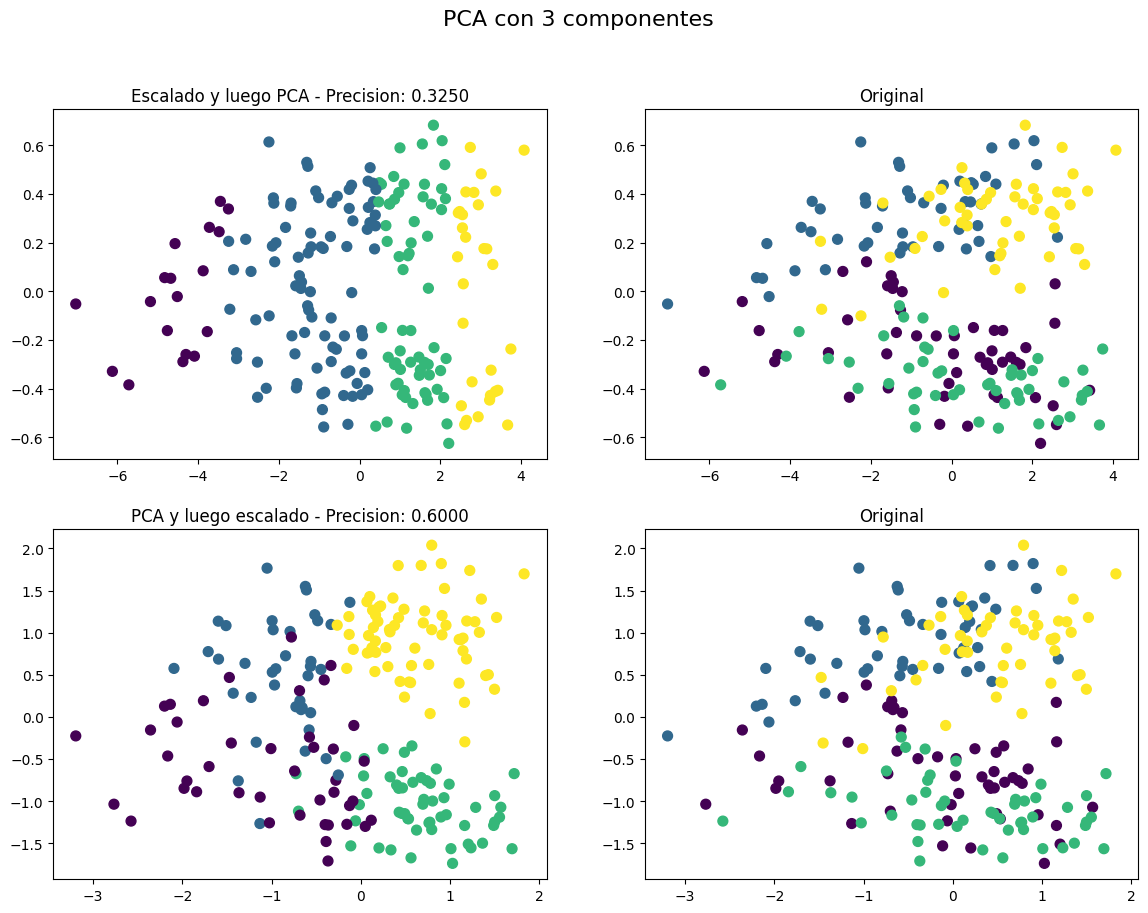

In [126]:
X = crabs.drop(columns=["sp", "sex"])
y = crabs[["sp", "sex"]]
original = pd.factorize(pd.Series(zip(y["sp"], y["sex"])))[0]

X_log = np.log(X)
X_scaled = scale(X_log, axis=0)

# Probar PCA con 2 y 3 componentes
components_list = [2,3]
for components in components_list:
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X_log).astype(np.double)
    X_pca_scaled = scale(X_pca, axis=0)

    pca = PCA(n_components=components)
    X_scaled_pca = pca.fit_transform(X_scaled).astype(np.double)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"PCA con {components} componentes", fontsize=16)

    # 4 clusters ya que hay dos especies y dos sexos
    clusters = cut_tree(linkage(X_scaled_pca, method='complete'), 4)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[0][0].set_title("Escalado y luego PCA - " + f"Precision: {precision:.4f}")
    axes[0][0].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=clusters, cmap="viridis", s=50)
    axes[0][1].set_title("Original")
    axes[0][1].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=original, cmap="viridis", s=50)

    clusters = cut_tree(linkage(X_pca_scaled, method='complete'), 4)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[1][0].set_title("PCA y luego escalado - " + f"Precision: {precision:.4f}")
    axes[1][0].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=clusters, cmap="viridis", s=50)
    axes[1][1].set_title("Original")
    axes[1][1].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=original, cmap="viridis", s=50)

# Lampone

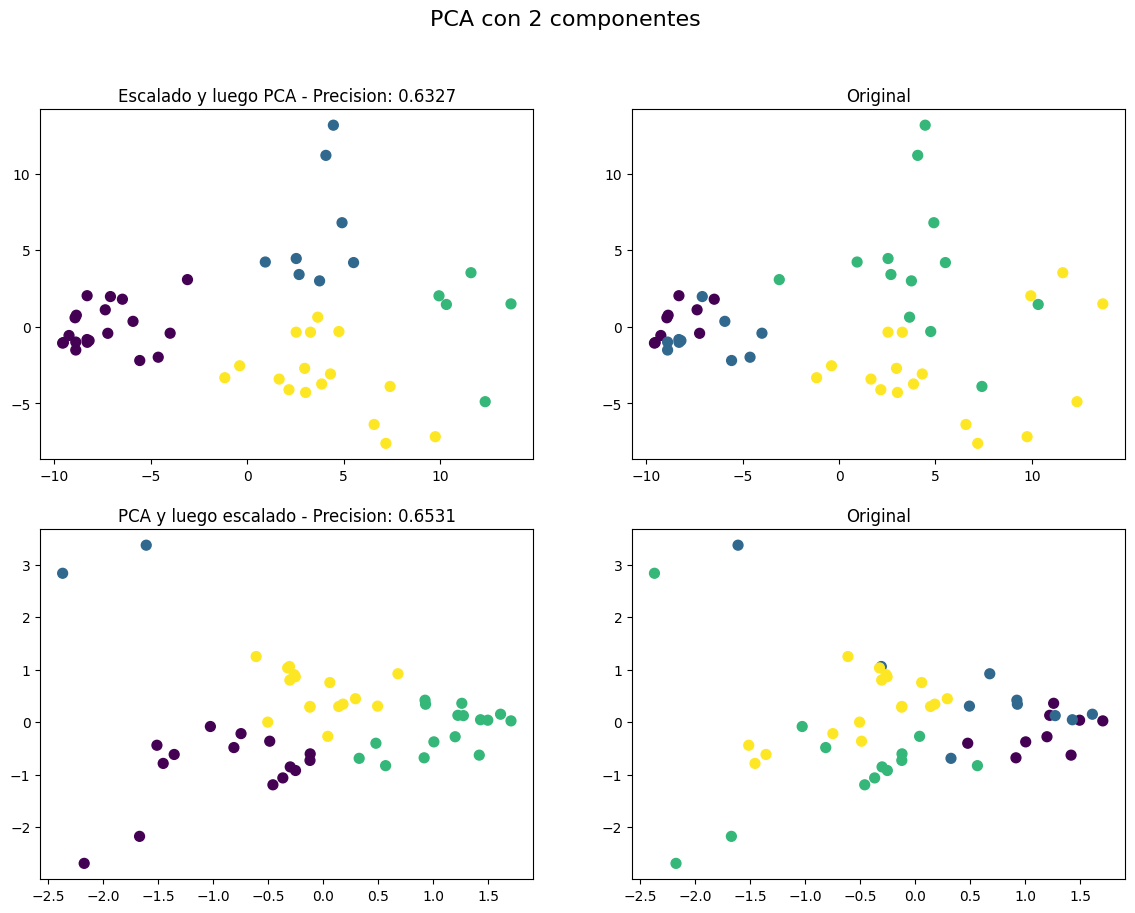

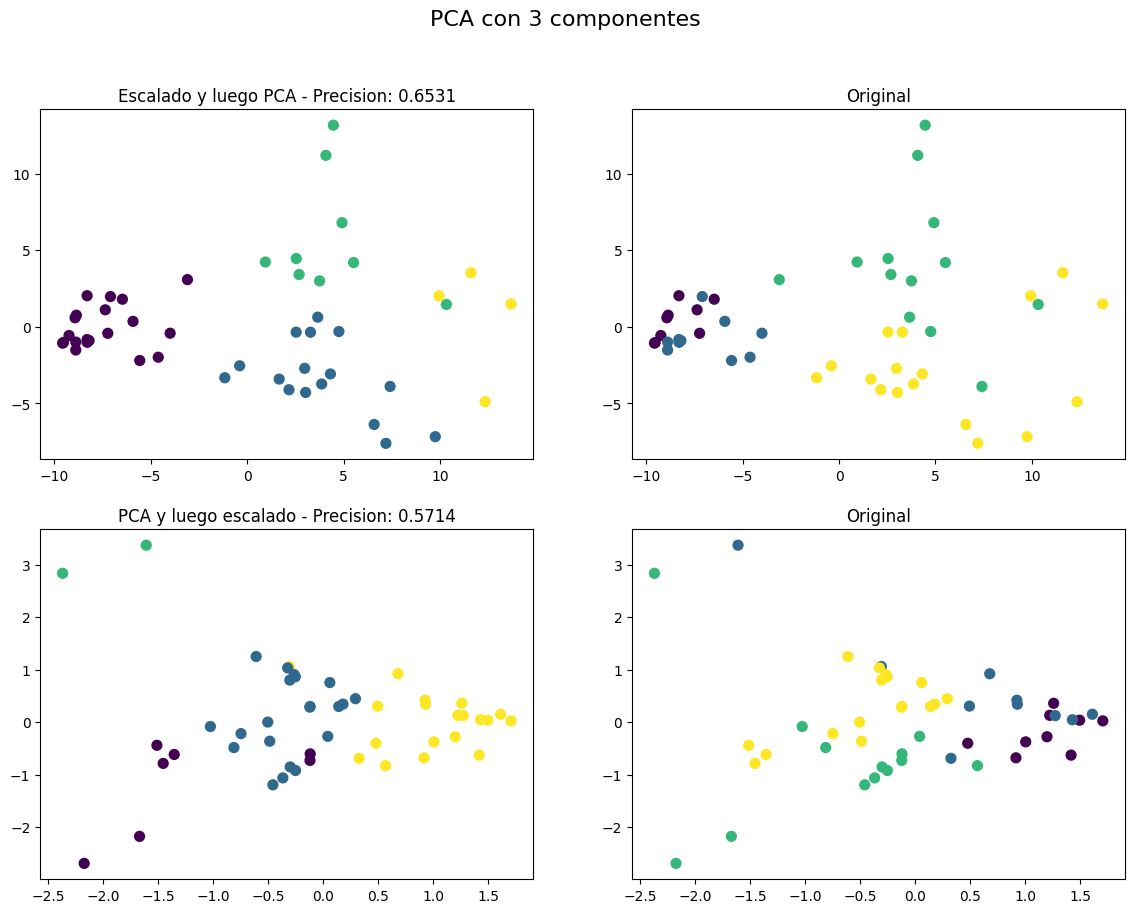

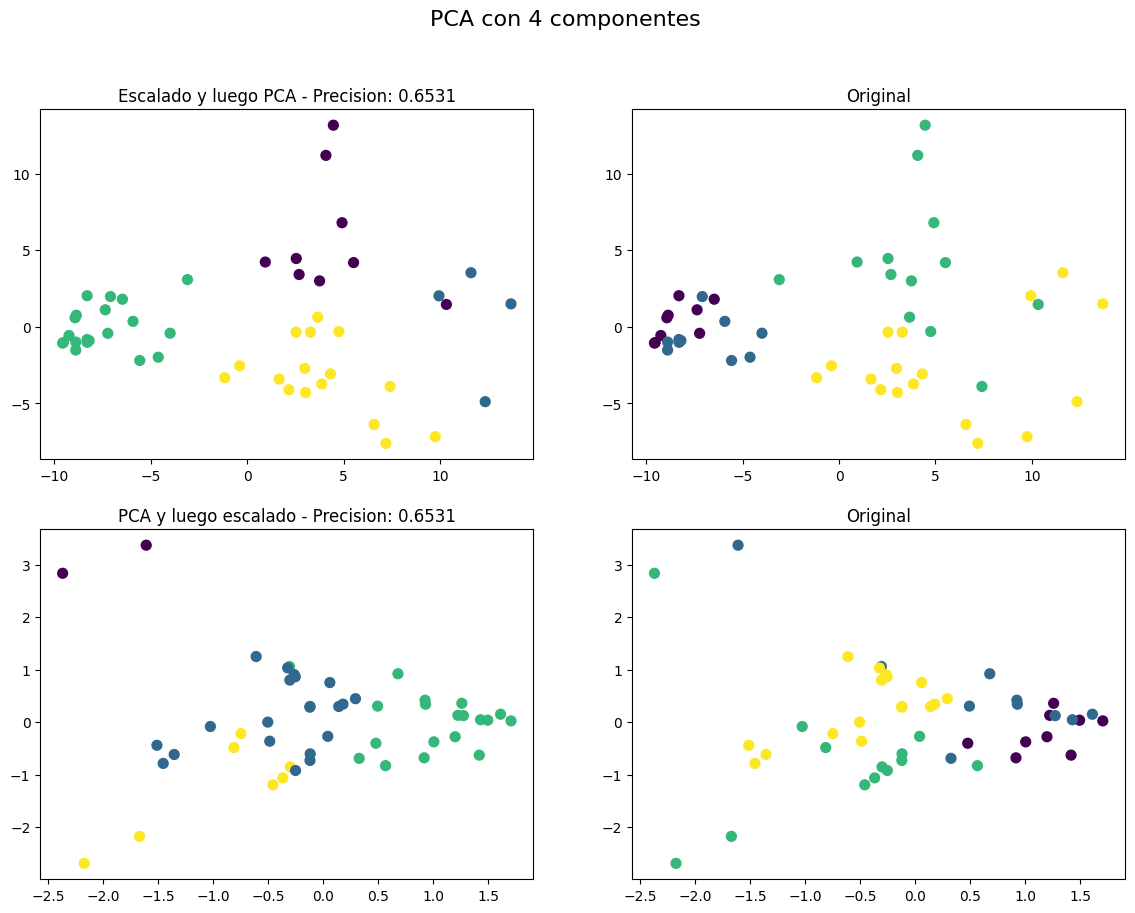

In [ ]:
X = lampone.drop(columns=lampone.columns[[0,142,143]])
y = lampone[lampone.columns[[0,142]]]
original = pd.factorize(pd.Series(zip(lampone.iloc[:, 0], lampone.iloc[:, 142])))[0]

#X_log = np.log(X)
X_scaled = scale(X, axis=0)


# Probar PCA con 2 y 3 componentes
components_list = [2,3,4]
for components in components_list:
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X)
    X_pca_scaled = scale(X_pca, axis=0)

    pca = PCA(n_components=components)
    X_scaled_pca = pca.fit_transform(X_scaled)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"PCA con {components} componentes", fontsize=16)

    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_scaled_pca)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[0][0].set_title("Escalado y luego PCA - " + f"Precision: {precision:.4f}")
    axes[0][0].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=clusters, cmap="viridis", s=50)
    axes[0][1].set_title("Original")
    axes[0][1].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=original, cmap="viridis", s=50)

    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_pca_scaled)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[1][0].set_title("PCA y luego escalado - " + f"Precision: {precision:.4f}")
    axes[1][0].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=clusters, cmap="viridis", s=50)
    axes[1][1].set_title("Original")
    axes[1][1].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=original, cmap="viridis", s=50)

# Ejercicio 2
## GAP

In [91]:
def gap_statistic(X, max_k, ran_samples=3, plot=False):
    shape = X.shape
    max_PCAcomponents = min(shape)
    results = [] #pd.DataFrame({'clusters':[], 'gap':[], 'std':[], 's':[]})
    for k in range(1, max_k + 1):
        km = KMeans(n_clusters=k, n_init=10, random_state=0)
        km.fit(X)
        
        # inertia es la dispersión
        dispersion = km.inertia_

        disps_samples = np.zeros(ran_samples)

        for i in range(ran_samples):
            # Generar datos aleatorios uniformes en el mismo rango que X
            # Usamos PCA 
            pca = PCA(n_components=max_PCAcomponents)
            X_pca = pca.fit_transform(X)
            random_data_pca = np.random.uniform(low=np.min(X_pca, axis=0), high=np.max(X_pca, axis=0), size=(shape[0], max_PCAcomponents))
            # Volvemos al espacio original
            #random_data = pca.inverse_transform(random_data_pca)
            km.fit(random_data_pca)
            disps_samples[i] = km.inertia_

        gap = np.mean(np.log(disps_samples)) - np.log(dispersion)
        std = np.std(np.log(disps_samples)) 
        #l = np.mean(np.log(disps_samples))
        #std = np.sqrt(np.mean((np.log(disps_samples) - l)**2))
        s = std * np.sqrt(1 + (1 / ran_samples))
        results.append({'clusters':k, 'gap':gap, 'std':std, 's':s})
    results_df = pd.DataFrame(results)

    opt_clusters = None
    opt_clusters_idx = None
    for i in range(1, len(results_df)):
        if results_df.loc[i-1, 'gap'] >= results_df.loc[i, 'gap'] - results_df.loc[i, 's']:
            opt_clusters = results_df.loc[i-1, 'clusters']
            opt_clusters_idx = i-1
            break

    if plot:
        plt.figure(figsize=(8,6))
        plt.errorbar(results_df['clusters'], results_df['gap'], yerr=results_df['std'], fmt='o-', capsize=5, label='data with error')
        plt.scatter(opt_clusters, results_df.loc[opt_clusters_idx,'gap'], color='red', s=100, zorder=5, label='highlighted point')
        plt.show()

    return opt_clusters, results_df

# Estabilidad

In [114]:
def compute_similarity_matrix(v):
    a = np.sqrt(np.outer(v, v))
    m = np.divide(a, -a, out=np.zeros_like(a), where=a != 0) + 2 * (a == np.round(a))
    return m

def plot_stability(similarities, k):
    cmap = plt.cm.tab10
    color1 = cmap(k / 10)
    similarities = np.sort(similarities)
    cumulative = np.arange(1, len(similarities) + 1) / len(similarities)
    plt.plot(similarities, cumulative, '.', markersize=4, color=color1, label=f'k={k}')

#from sklearn.metrics import adjusted_rand_score
def estabilidad(X, max_k, ran_samples=5, plot=False):
    shape = X.shape
    results = [] 
    n = shape[0]
    plt.figure(figsize=(8, 6))
    plt.xlabel('similarity')
    plt.ylabel('cumulative')
    plt.grid(False)
    for k in range(2, max_k + 1):
        scores = []
        labels_lists = []
        for i in range(ran_samples):
            ind = np.random.choice(n, int(0.85 * n), replace=False)
            cc = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X[ind]).labels_
            v = np.zeros(n, dtype=int)
            v[ind] = cc + 5
            labels_lists.append(v)

        for i in range(ran_samples):
            for j in range(i+1, ran_samples):
                v1 = labels_lists[i]
                v2 = labels_lists[j]
                m1 = compute_similarity_matrix(v1)
                m2 = compute_similarity_matrix(v2)

                # Calcular el score de estabilidad
                validos = np.sum((v1 * v2) > 0)
                if validos > 1:
                    score = np.sum((m1 * m2)[np.triu_indices(n, k=1)] > 0) / (validos * (validos - 1) / 2)
                else:
                    score = 0  # Evita división por cero
                #score = adjusted_rand_score(v1,v2)
                scores.append(score)

        
        plot_stability(scores, k)
        results.append({'clusters':k, 'stability':np.mean(scores), 'std':np.std(scores)})
    results_df = pd.DataFrame(results)

    if plot:
        plt.legend()
        plt.show()
        #plt.figure(figsize=(8,6))
        #plt.errorbar(results_df['clusters'], results_df['stability'], yerr=results_df['std'], fmt='o-', capsize=5, label='data with error')

    best = results_df.loc[results_df['stability'].idxmax()]['clusters']
    return best,results_df

In [85]:
def genera_cuatro_gausianas(n = 100, gap = 2):
    gausianas = np.zeros((4*n, 3))

    centers = np.array([
        [-gap, -gap],
        [-gap, gap],
        [gap, -gap],
        [gap, gap]
    ])

    for i, center in enumerate(centers):
        x = np.random.normal(center[0], size=n)
        y = np.random.normal(center[1], size=n)
        c = np.repeat(i, n)
        gausianas[(i*n):((i+1)*n), :] = np.vstack((x, y, c)).T

    return gausianas

# Ejercicio 3: Cuatro gausianas

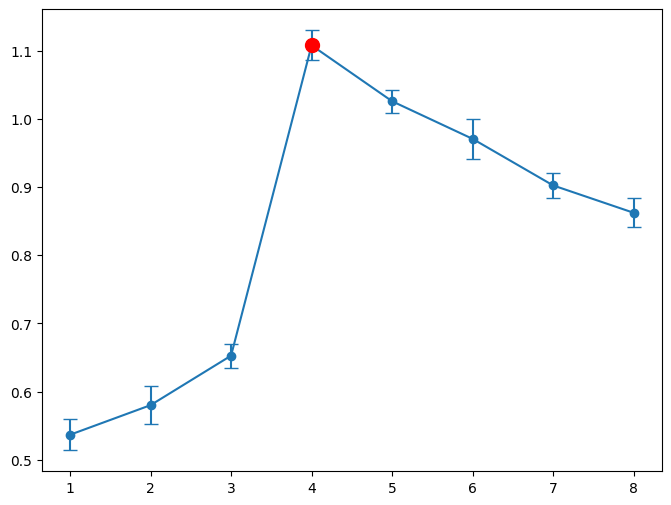

Optimal k from Gap Statistic: 4


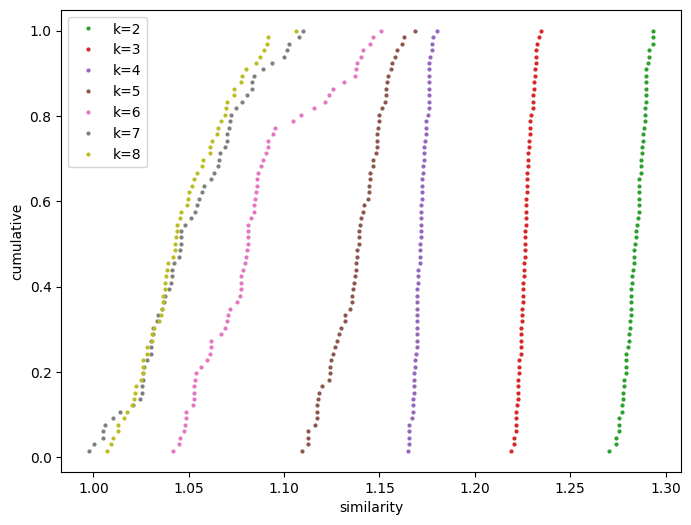

Optimal k from Stability: 2.0


In [108]:
gaus = genera_cuatro_gausianas(gap=2.5) 
#plt.figure(figsize=(8,6))
#plt.scatter(gaus[:, 0], gaus[:, 1], c=gaus[:, 2], cmap='tab10', s=30)
k, _ = gap_statistic(gaus[:, :2], max_k=8, ran_samples=5, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(gaus[:, :2], max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)



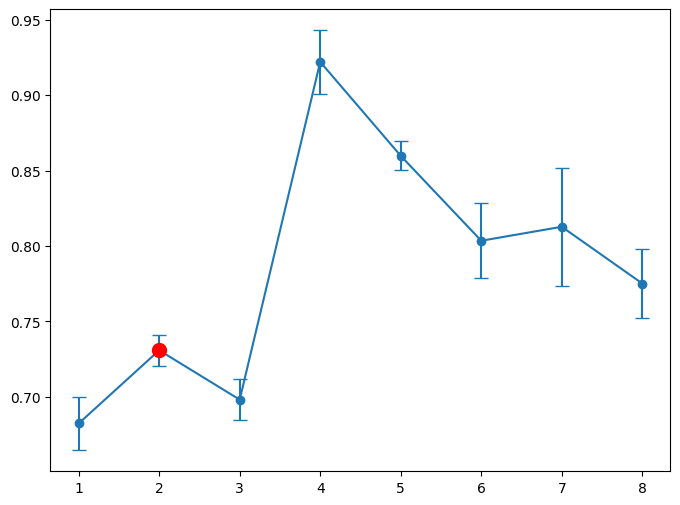

Optimal k from Gap Statistic: 2


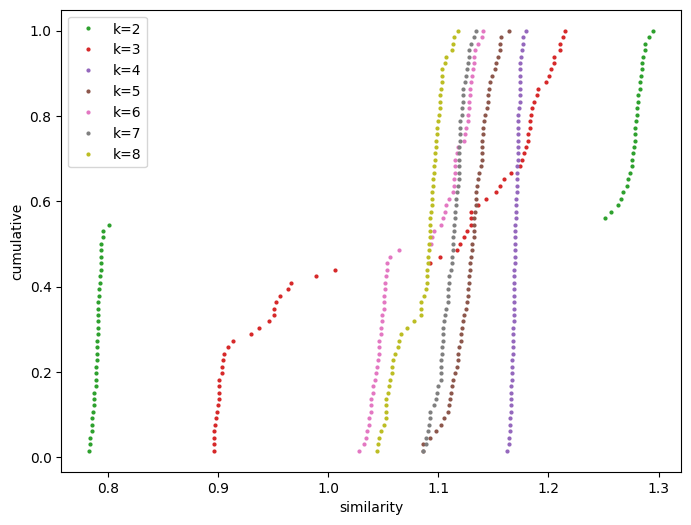

Optimal k from Stability: 4.0


In [109]:
gaus = genera_cuatro_gausianas(gap=2) 
k, _ = gap_statistic(gaus[:, :2], max_k=8, ran_samples=5, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(gaus[:, :2], max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)

# Iris

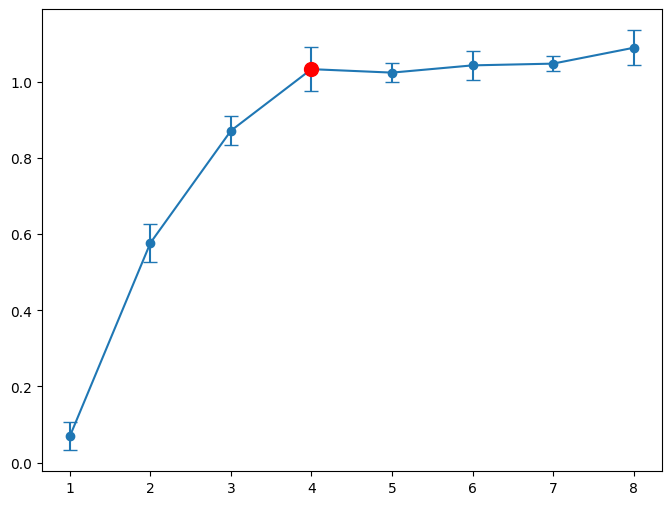

Optimal k from Gap Statistic: 4


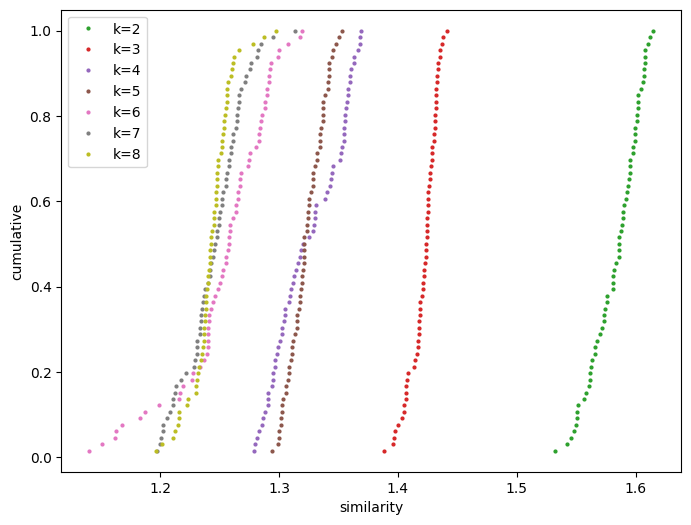

Optimal k from Stability: 2.0


In [119]:
# Cargo dataset iris
iris = load_iris(as_frame=True)
X = np.array(iris.data)
y = iris.target

k, _ = gap_statistic(X, max_k=8, ran_samples=6, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(X, max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)

# Lampone

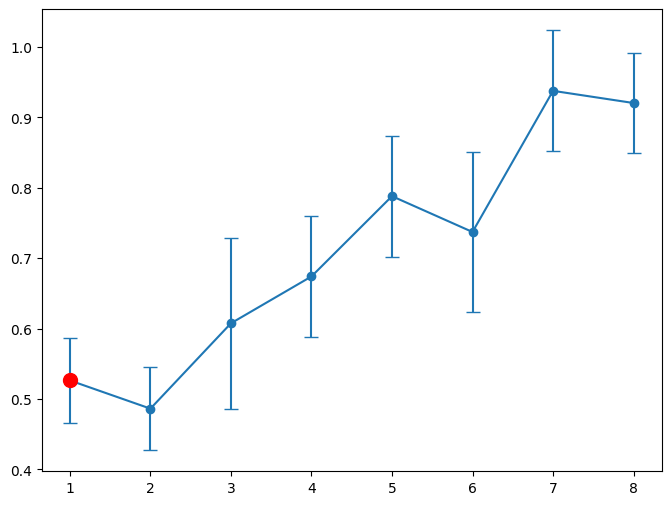

Optimal k from Gap Statistic: 1


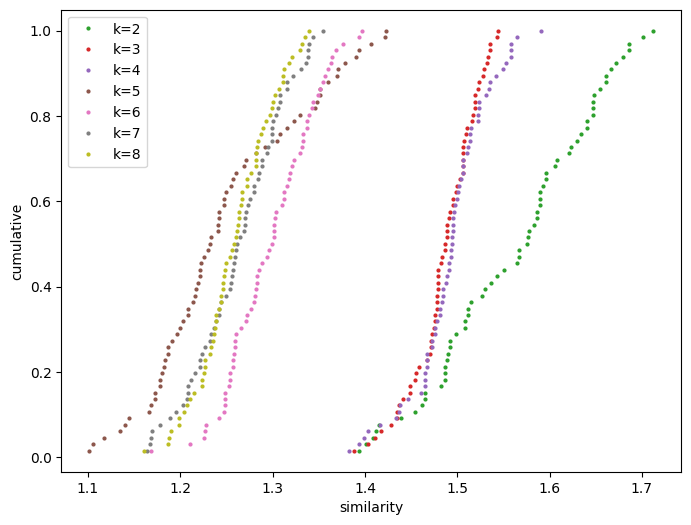

Optimal k from Stability: 2.0


In [121]:
X = np.array(lampone.drop(columns=lampone.columns[[0,142,143]]))
y = lampone[lampone.columns[[0,142]]]

k, _ = gap_statistic(X, max_k=8, ran_samples=6, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(X, max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)